In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
from pysindy import EnsembleOptimizer
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
import matplotlib as mpl
# mpl.rcParams.update({"text.usetex":True})


/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()


In [2]:
exp_data = LorenzExp
initial_state = jnp.array([ -5, 0., 5])
initial_state = jnp.array([ -8,8,27.])
dt = 0.5
noise_var = 0.0
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 505
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

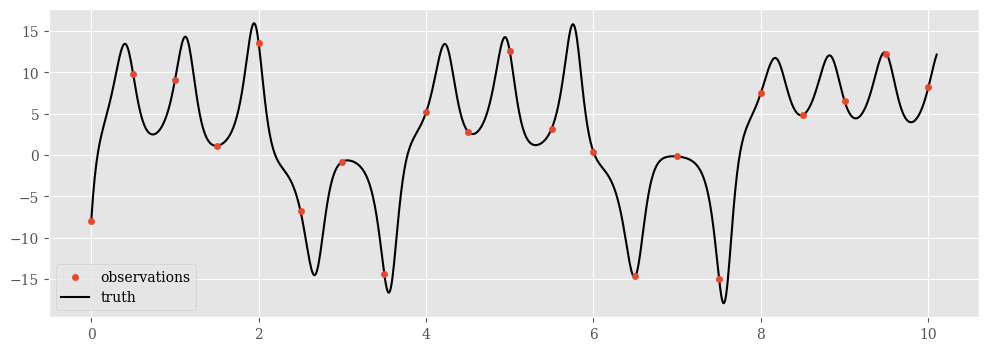

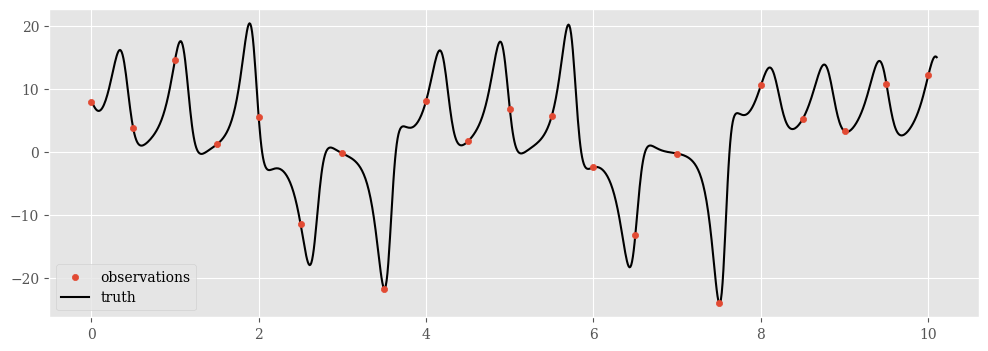

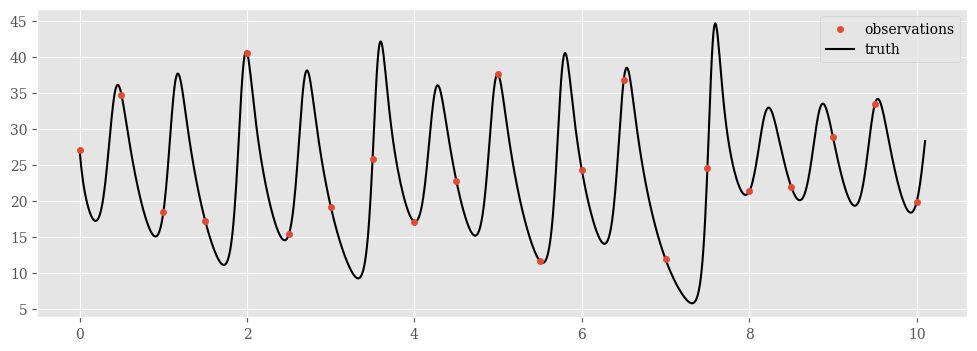

In [3]:
t_grid = jnp.linspace(t0,t1,1000)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 20,zorder=2)
    plt.plot(t_grid,true_states[:,dim],label = 'truth',c='black',zorder=1)
    plt.legend()
    plt.show()


In [4]:
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 10000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 1e5
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.5,alpha = 0.01)
    )
# sparsifier = pySindySparsifier(EnsembleOptimizer(STLSQ(threshold = 0.5,alpha = 0.1),bagging=True,n_models = 100))

# sparsifier = pySindySparsifier(
#     MIOSR(target_sparsity = 7,alpha = 0.1)
#     )


optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)

# nodes,weights = legendre_nodes_weights(500,t0,t1)

model.fit(
    expdata.t_train,
    expdata.x_train,
    t_colloc = expdata.t_colloc,
    w_colloc = expdata.w_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


{'show_progress': True, 'sigma2_est': Array(43.84970067, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Warm Start


  0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 0, loss = 7.387e+08, gradnorm = 6.238e+08, alpha = 11.25, improvement_ratio = 0.4318
Iteration 1, loss = 3.533e+08, gradnorm = 6.195e+09, alpha = 25.31, improvement_ratio = 0.5218
Iteration 2, loss = 1.876e+08, gradnorm = 3.006e+09, alpha = 37.97, improvement_ratio = 0.4689
Iteration 3, loss = 4.067e+07, gradnorm = 5.741e+09, alpha = 37.97, improvement_ratio = 0.7832
Iteration 4, loss = 1.023e+07, gradnorm = 1.585e+09, alpha = 37.97, improvement_ratio = 0.7484
Iteration 5, loss = 7.47e+06, gradnorm = 7.1e+08, alpha = 56.95, improvement_ratio = 0.2702
Iteration 100, loss = 726.7, gradnorm = 2.702e+05, alpha = 506.2, improvement_ratio = 0.7146
Iteration 200, loss = 489.8, gradnorm = 1.161e+06, alpha = 337.5, improvement_ratio = 0.289
Iteration 300, loss = 306.5, gradnorm = 3.621e+05, alpha = 225.0, improvement_ratio = 0.5172
Iteration 400, loss = 247.7, gradnorm = 2.853e+05, alpha = 150.0, improvement_ratio = 0.5218
Iteration 500, loss = 221.4, gradnorm = 3.236e+05, alpha = 100

In [5]:
model.print()

(x)' = -10.008 x + 10.006 y
(y)' = 28.073 x + -1.012 y + -1.003 x z
(z)' = -2.663 z + 1.001 x y


In [6]:
model.optimizer.solver_settings

LMSettings(max_iter=10000, atol_gradnorm=1e-08, cmin=0.05, line_search_increase_ratio=1.5, max_line_search_iterations=20, min_alpha=1e-16, max_alpha=100.0, init_alpha=5.0, step_adapt_multiplier=1.2, callback=None, print_every=100, track_iterates=False, show_progress=True, use_jit=True, no_tqdm=False)

In [7]:
print(model)


--------Trajectory Model--------

MLE Adapted Cholesky Parametrized RKHS Trajectory Model
kernel: 194.425 + 43.14Matern(5,0.04)
derivative_orders: (0, 1)
nugget: 1e-08


--------Feature Library---------
degree: 2
include_bias: True
include_interaction: True
interaction_only: False
order: C

--------Optimizer Setup--------

Alternating Active Set Optimizer
beta_reg: 0.001,
sparsifier: STLSQ(alpha=0.01, threshold=0.5)
data_weight: 1.0
colloc_weight: 100000.0




In [8]:
expdata.print()

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


In [9]:
model.print()

(x)' = -10.008 x + 10.006 y
(y)' = 28.073 x + -1.012 y + -1.003 x z
(z)' = -2.663 z + 1.001 x y


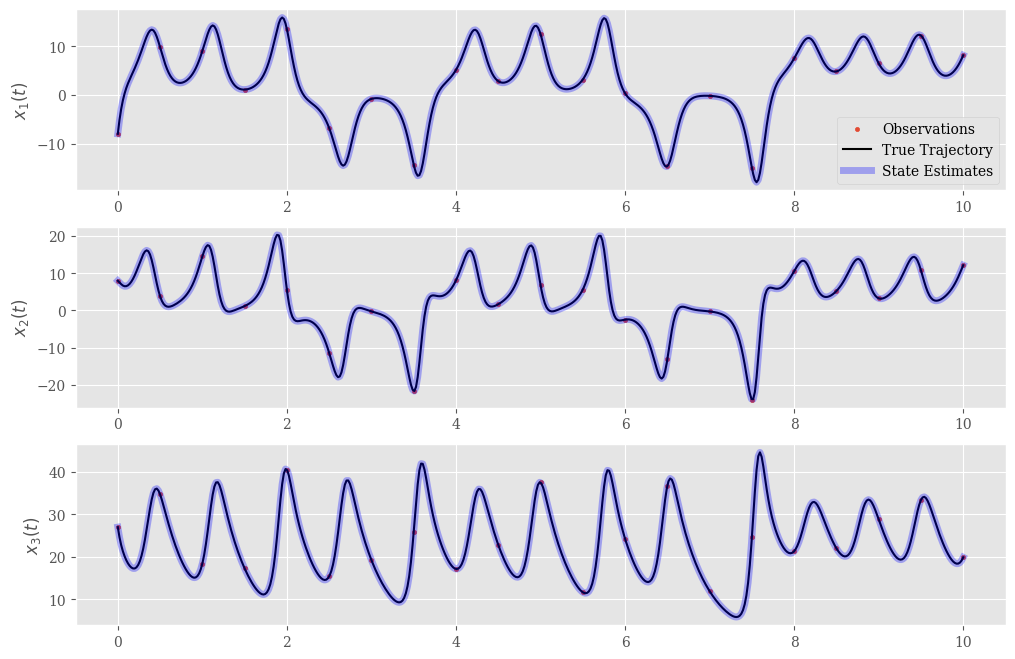

In [10]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
plt.figure(figsize=(12,8))
for dim in range(3):
    plt.subplot(3,1,dim+1)
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'Observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'True Trajectory',c='black')
    plt.plot(t_grid,state_preds[:,dim],label = 'State Estimates',c ='blue',alpha = 0.3,lw = 5)
    if dim ==0:
        plt.legend()
    plt.ylabel(f"$x_{dim+1}(t)$")
# plt.savefig("figures/lorenz_prelim.pdf")

## Custom plot in style of manuscript

In [11]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['font.family'] = 'serif'

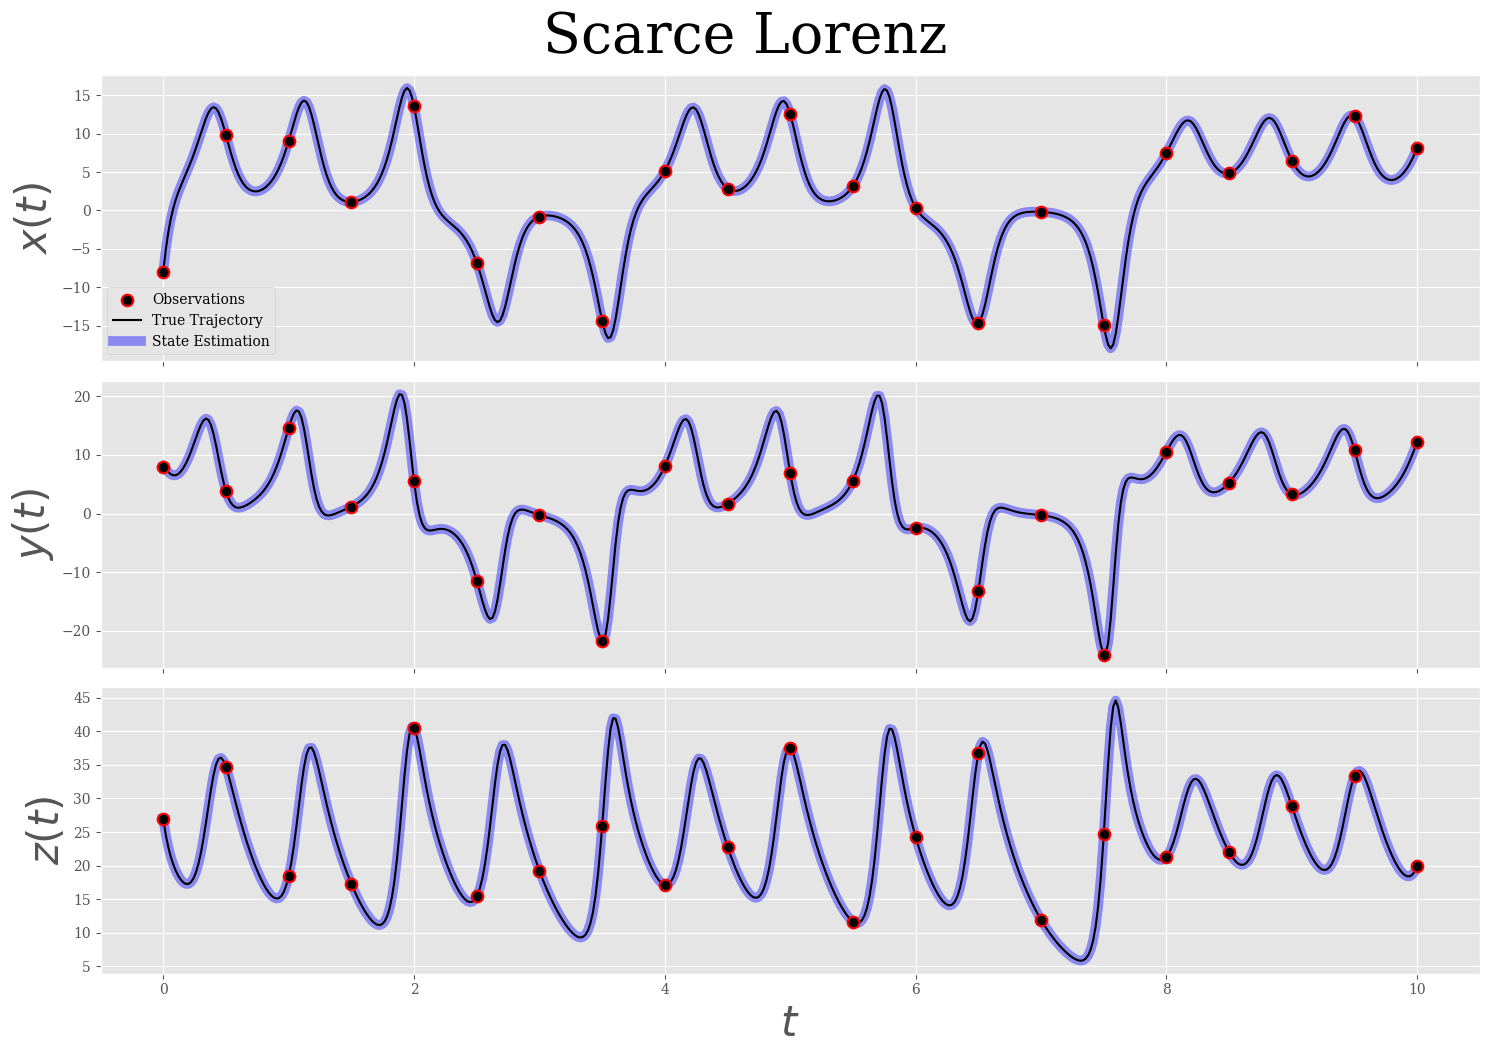

In [12]:
fig, axs  = plt.subplots(3,1, figsize=(15,10),sharex=True)

axs = axs.flatten()

y_labels = [r"$x(t)$", r"$y(t)$", r"$z(t)$"]
for idx, ax in enumerate(axs):
    ax.scatter(expdata.t_train,expdata.x_train[:,idx],zorder = 3, facecolors='black', edgecolors='red', label="Observations", s=70,lw=1.5)
    ax.plot(t_grid,true_states[:,idx],label = 'True Trajectory',c='black',zorder=2)
    ax.plot(t_grid,state_preds[:,idx],label='State Estimation', linestyle='-',c='blue', alpha=0.4,lw=7,zorder=1)

    ax.set_ylabel(y_labels[idx],size=30, rotation = 90)

    if idx == 0:
        ax.legend()
    if idx == len(y_labels) - 1:
        ax.set_xlabel(r"$t$", size=30)

plt.tight_layout()
plt.suptitle("Scarce Lorenz", y=1.05, size=40)
plt.show()



## simulated new trajectories

In [13]:
import diffrax
from data.lorenz import lorenz_system


true_system = jax.jit(lorenz_system)

jit_lor_pred = jax.jit(model.predict)


def learned_system(t,x,args):
    return jit_lor_pred(x)



def simulate_sol(y0,system, t0=expdata.t0,t1=expdata.t1,dt=expdata.dt,t_eval = expdata.t_true, args = None):
    term = diffrax.ODETerm(system)
    solver = diffrax.Tsit5()

    save_at = diffrax.SaveAt(dense=True)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0 = t0,
        t1=t1,
        dt0=dt,
        y0=y0,
        args = args,
        saveat=save_at,
        max_steps=int(10*(t1-t0)/dt)
    )

    return jax.vmap(sol.evaluate)(t_eval)


In [14]:
lorenz_args = (expdata.sigma,expdata.rho, expdata.beta)
x_train = expdata.x_train

t_new = expdata.t_true
t_new = jnp.linspace(0,12, 1010)

x_true_extend = simulate_sol(x_train[-1],system=true_system,t0=t_new[0],t1=t_new[-1], t_eval=t_new, args=lorenz_args)
x_sim_extend = simulate_sol(x_train[-1],system=learned_system,t0=t_new[0],t1=t_new[-1], t_eval=t_new,)

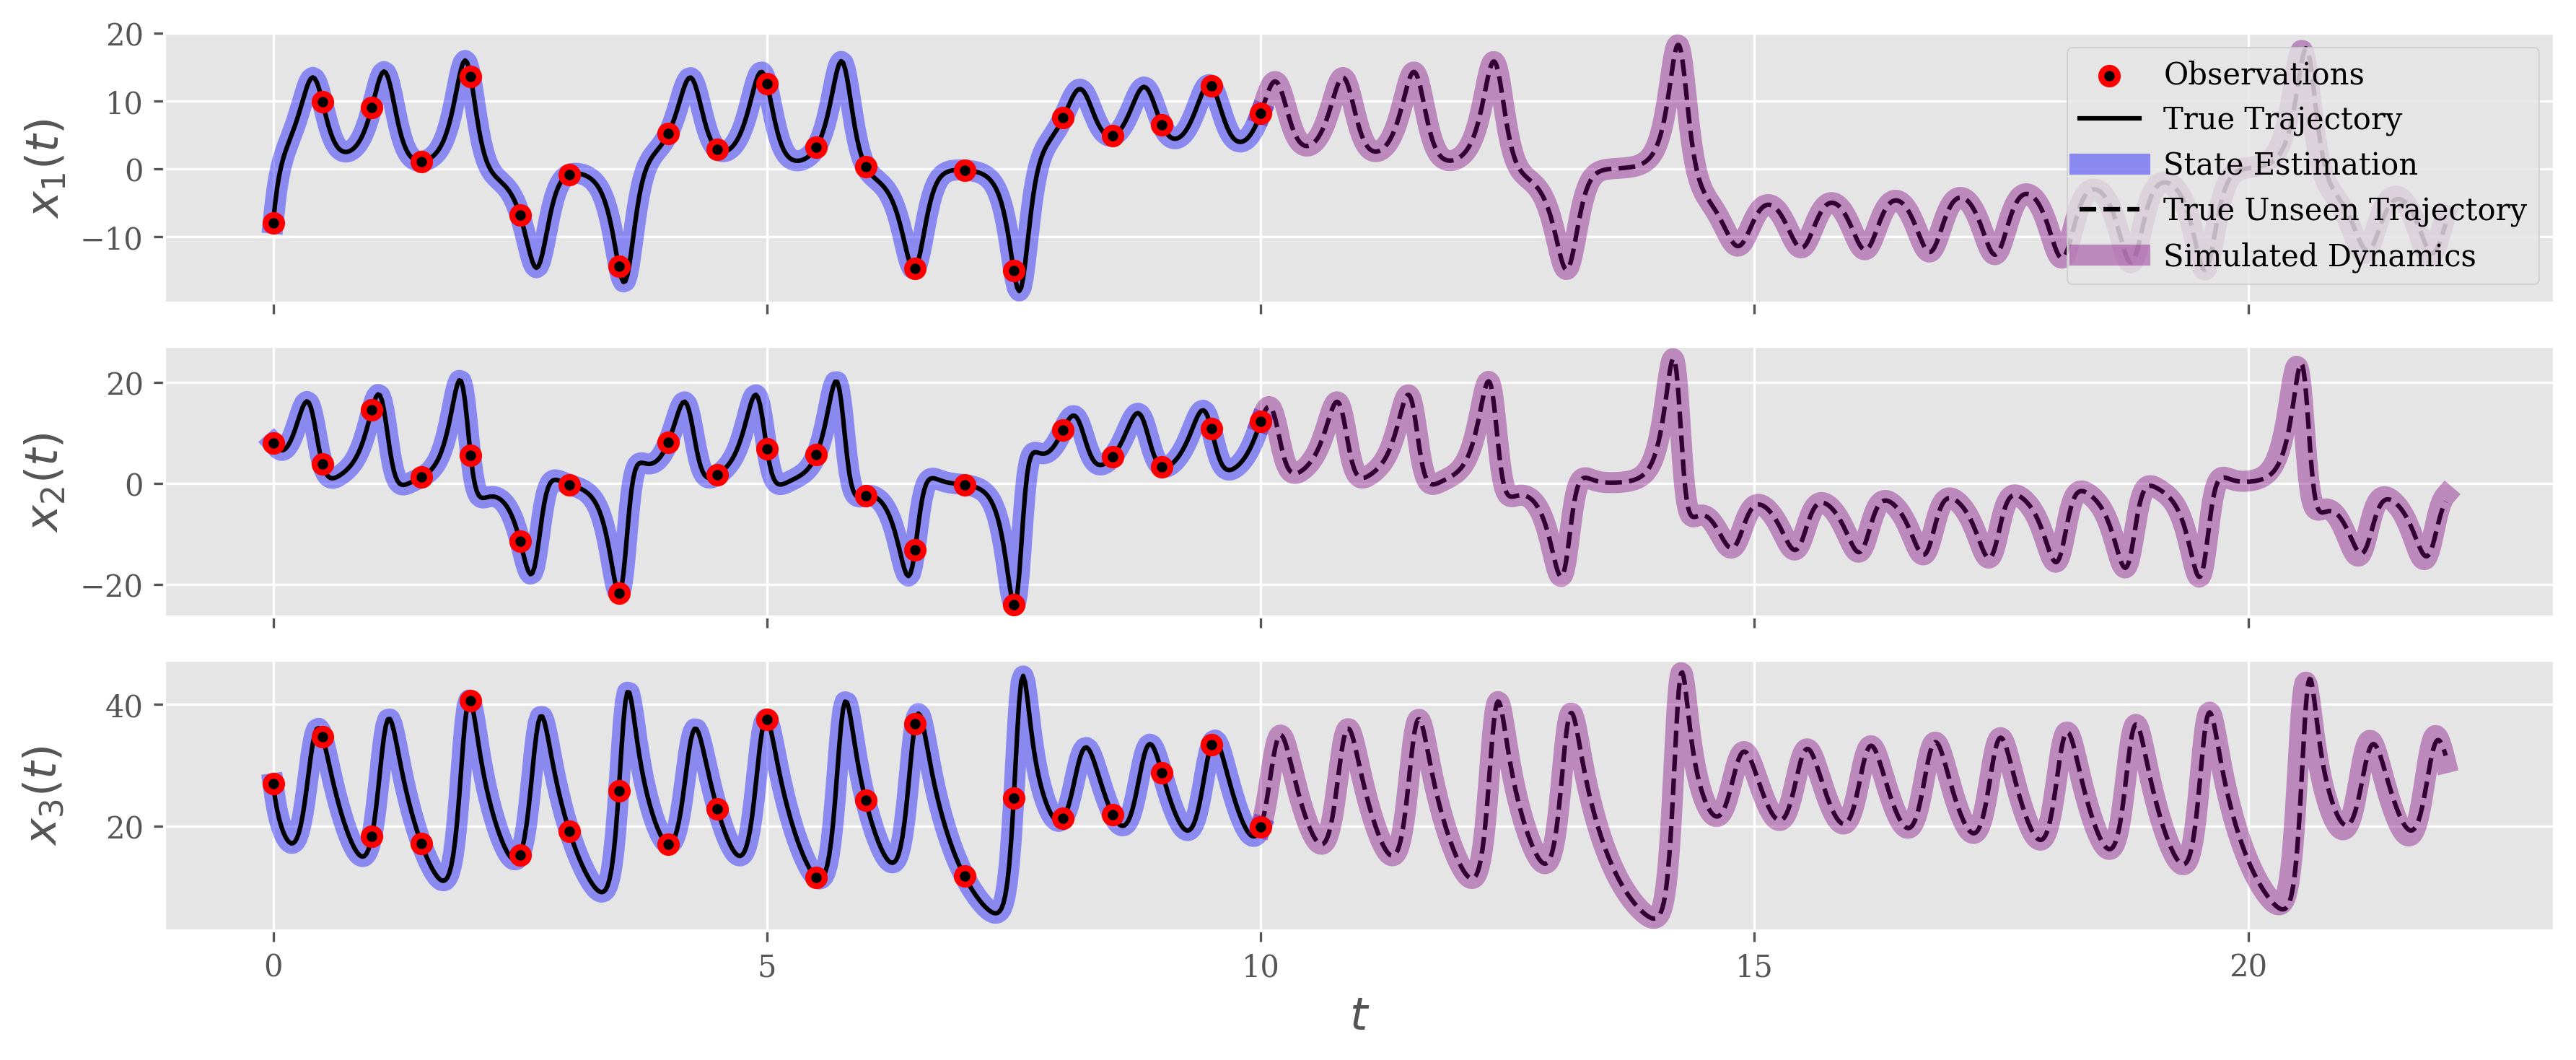

In [15]:
fig, axs  = plt.subplots(3,1, figsize=(12,5),sharex=True,dpi=300)

axs = axs.flatten()
lw=1.5

y_labels = [r"$x_1(t)$", r"$x_2(t)$", r"$x_3(t)$"]
for idx, ax in enumerate(axs):
    ax.scatter(expdata.t_train,expdata.x_train[:,idx],zorder = 3, facecolors='black', edgecolors='red', label="Observations", s=30,lw=2)
    ax.plot(t_grid,true_states[:,idx],label = 'True Trajectory',c='black',zorder=2)
    ax.plot(t_grid,state_preds[:,idx],label='State Estimation', linestyle='-',c='blue', alpha=0.4,lw=7,zorder=1)

    # extended
    t_extend = t_new + t_grid[-1]
    ax.plot(t_extend, x_true_extend[:,idx],c='black', linestyle='--', label='True Unseen Trajectory')
    ax.plot(t_extend, x_sim_extend[:,idx],c='purple',alpha=0.4, lw=7,linestyle='-',label='Simulated Dynamics')

    if idx> 1:
        ax.set_ylabel(y_labels[idx],size=15, rotation = 90,labelpad=13)
    else:
        ax.set_ylabel(y_labels[idx],size=15, rotation = 90)

    if idx == 0:
        ax.legend(loc ='upper right',prop={'size':10})
    if idx == len(y_labels) - 1:
        ax.set_xlabel(r"$t$", size=15)

plt.tight_layout()
# plt.suptitle("Scarce Lorenz", y=1.05, size=40)
plt.savefig(f"scarce_lorenz_dt_{dt}_noise_{noise_var}_2.pdf")
plt.show()

## Long time simulation

In [ ]:
lorenz_args = (expdata.sigma,expdata.rho, expdata.beta)

t_new = expdata.t_true
t_new = jnp.linspace(0,100, 1010)

x_true_extend = simulate_sol(x_train[-1],system=true_system,t0=t_new[0],t1=t_new[-1], t_eval=t_new, args=lorenz_args)
x_sim_extend = simulate_sol(x_train[-1],system=learned_system,t0=t_new[0],t1=t_new[-1], t_eval=t_new,)

In [ ]:
t_new += t_grid[-1]

In [ ]:
idx_25 = 1010//4
j = 0

In [ ]:
for j in range(4):
    fig, axs  = plt.subplots(3,1, figsize=(15,10),sharex=True,dpi=300)

    axs = axs.flatten()

    y_labels = [r"$x_0(t)$", r"$x_1(t)$", r"$x_2(t)$"]
    for idx, ax in enumerate(axs):
        # ax.scatter(expdata.t_train,expdata.x_train[:,idx],zorder = 3, facecolors='black', edgecolors='red', label="Observations", s=70,lw=1.5)
        # ax.plot(t_grid,true_states[:,idx],label = 'True Trajectory',c='black',zorder=2)
        # ax.plot(t_grid,state_preds[:,idx],label='State Estimation', linestyle='-',c='blue', alpha=0.4,lw=7,zorder=1)

        # extended
        t_extend = t_new
        ax.plot(t_extend[idx_25*j:idx_25*(j+1)], x_true_extend[idx_25*j:idx_25*(j+1),idx],c='black', linestyle='--', label='True Unseen Trajectory')
        ax.plot(t_extend[idx_25*j:idx_25*(j+1)], x_sim_extend[idx_25*j:idx_25*(j+1),idx],c='purple',alpha=0.4, lw=5,linestyle='-',label='Simulated Dyanmics')

        ax.set_ylabel(y_labels[idx],size=15, rotation = 90)

        if idx == 0:
            ax.legend(loc ='upper right',prop={'size':10})
        if idx == len(y_labels) - 1:
            ax.set_xlabel(r"$t$", size=15)

    plt.tight_layout()
    # plt.suptitle("Scarce Lorenz", y=1.05, size=40)
    # plt.savefig(f"scarce_lorenz_dt_{dt}_noise_{noise_var}.pdf")
    plt.show()

# Regular SINDy benchmark

In [ ]:
import numpy as np
import pysindy as ps

from pysindy import SmoothedFiniteDifference
from pysindy import STLSQ
from pysindy import EnsembleOptimizer


t_train = np.array(expdata.t_train)
x_train = np.array(expdata.x_train)
feature_library = ps.PolynomialLibrary(degree =2)

optimizer = EnsembleOptimizer(STLSQ(threshold = 0.5,alpha = 0.01),bagging=True,n_models = 200)
optimizer = STLSQ(threshold = 0.5,alpha = 0.01)
ps_model = ps.SINDy(
    differentiation_method=SmoothedFiniteDifference(),
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y","z"],
)
ps_model.fit(x_train,t_train)
ps_model.print()
print()
expdata.print()

In [ ]:
ps_model

In [ ]:
print(ps_model.feature_library._repr_html_())

In [ ]:
# Same library terms as before
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]


In [ ]:
ode_lib = ps.WeakPDELibrary(
    function_library=feature_library,
    spatiotemporal_grid=t_train,
    is_uniform=True,
    K=500,
)
optimizer = EnsembleOptimizer(
    STLSQ(threshold = 0.3,alpha = 0.005),
    bagging=True,
    n_models = 200)

# sr3_optimizer = ps.SR3(
#     reg_weight_lam=0.5,
#     regularizer="l0",
#     max_iter=100000,
#     normalize_columns=True,
#     tol=1e-1
# )
ps_model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
ps_model.fit(x_train,t_train)
ps_model.print()


In [ ]:
model.coefficients()